In [1]:
# 1. Import thư viện cần thiết
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

Mounted at /content/drive


In [2]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/CMG.csv')
df1=df.reset_index()['Price']

In [3]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [4]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [5]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [6]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [7]:
# 7. Reshape input to be [samples, time steps, features] which is required for CNN
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
# 8. Khởi tạo mô hình CNN

# Xây dựng mô hình CNN
model = Sequential()

# Thêm lớp Convolutional
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(100,1)))

# Thêm lớp Pooling
model.add(MaxPooling1D(pool_size=2))

# Thêm lớp Flatten
model.add(Flatten())

# Thêm lớp Fully Connected
model.add(Dense(64, activation='relu'))

# Thêm lớp đầu ra
# model.add(Dense(10, activation='softmax'))
model.add(Dense(1))


In [9]:
# 9. Fit mô hình với dữ liệu train
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
14/14 [==============================] - 1s 29ms/step - loss: 0.0177 - val_loss: 0.0923
Epoch 2/100
14/14 [==============================] - 0s 15ms/step - loss: 0.0037 - val_loss: 0.0349
Epoch 3/100
14/14 [==============================] - 0s 15ms/step - loss: 0.0017 - val_loss: 0.0133
Epoch 4/100
14/14 [==============================] - 0s 15ms/step - loss: 0.0012 - val_loss: 0.0180
Epoch 5/100
14/14 [==============================] - 0s 15ms/step - loss: 0.0011 - val_loss: 0.0113
Epoch 6/100
14/14 [==============================] - 0s 15ms/step - loss: 9.3497e-04 - val_loss: 0.0146
Epoch 7/100
14/14 [==============================] - 0s 16ms/step - loss: 8.0912e-04 - val_loss: 0.0084
Epoch 8/100
14/14 [==============================] - 0s 15ms/step - loss: 7.6278e-04 - val_loss: 0.0091
Epoch 9/100
14/14 [==============================] - 0s 15ms/step - loss: 6.7301e-04 - val_loss: 0.0070
Epoch 10/100
14/14 [==============================] - 0s 15ms/step - loss: 5.9868e-0

In [10]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

2/2 [==============================] - 0s 6ms/step


In [11]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val, yval, ytest
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)
ytest = scaler.inverse_transform(ytest.reshape(-1,1))
yval = scaler.inverse_transform(yval.reshape(-1,1))


In [12]:
from sklearn.metrics import mean_absolute_error
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))

# Tính MAE cho Test và Validate
mae_test = mean_absolute_error(ytest, y_pred)
mae_val = mean_absolute_error(yval, y_pred_val)

# Tính MAPE cho Test và Validate
mape_test = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
mape_val = np.mean(np.abs((yval - y_pred_val) / yval)) * 100


print('Validation RMSE:', valid_rmse)
print("Validate MAE: ", mae_val)
print("Validate MAPE: ", mape_val)

print('Testing RMSE:', test_rmse)
print("Test MAE: ", mae_test)
print("Test MAPE: ", mape_test)

Validation RMSE: 1363.096751480678
Validate MAE:  1039.0802364864865
Validate MAPE:  2.4526042512241215
Testing RMSE: 2305.041326365714
Test MAE:  1813.5836476293102
Test MAPE:  3.5760480816532025


In [13]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[37:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1




0 day input [0.56905504 0.56206566 0.55707325 0.55807173 0.56206566 0.57205048
 0.58403227 0.6219746  0.61198978 0.61398674 0.58403227 0.60000799
 0.61198978 0.60200495 0.57804138 0.59102165 0.59102165 0.58203531
 0.59002316 0.59002316 0.58403227 0.57804138 0.57704289 0.59002316
 0.59002316 0.55208084 0.57005352 0.56306414 0.55008387 0.56406262
 0.57005352 0.56106718 0.53810208 0.56106718 0.55907021 0.56605959
 0.56206566 0.57205048 0.56805655 0.54009905 0.57804138 0.57205048
 0.57404745 0.55807173 0.571052   0.55607477 0.56206566 0.56306414
 0.56106718 0.5600687  0.55208084 0.55108235 0.55008387 0.56406262
 0.56306414 0.59002316 0.58103682 0.58403227 0.58403227 0.58702772
 0.58203531 0.58902468 0.58902468 0.58902468 0.5880262  0.5880262
 0.58503075 0.58503075 0.58203531 0.57804138 0.58003834 0.58203531
 0.58403227 0.58303379 0.58203531 0.58203531 0.58103682 0.58103682
 0.58103682 0.58003834 0.58003834 0.57704289 0.57205048 0.57205048
 0.57005352 0.56805655 0.56206566 0.56705807 0.5660

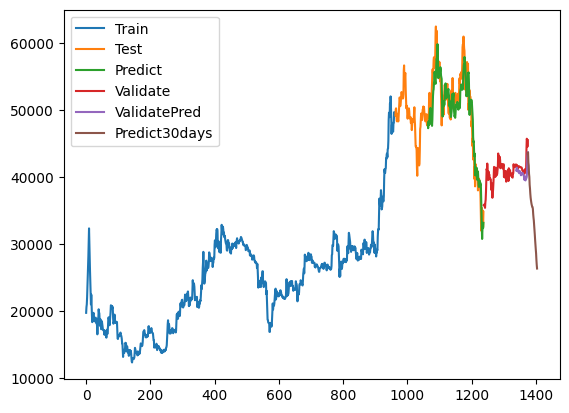

In [14]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

In [15]:
print(scaler.inverse_transform(lst_output))

[[43497.11616039]
 [43671.41731811]
 [42162.75434446]
 [41727.52229118]
 [40476.76366425]
 [40011.16165566]
 [38827.22886944]
 [38271.82730556]
 [37505.29261851]
 [36933.85541975]
 [36546.73325586]
 [36214.06360102]
 [35929.82618988]
 [35736.37927508]
 [35535.68237293]
 [35513.55483842]
 [35233.52594197]
 [34463.05435359]
 [33919.61720896]
 [33485.54324341]
 [32766.48418379]
 [32088.75363386]
 [31391.36991727]
 [30605.43726075]
 [29910.35927296]
 [29234.13155079]
 [28611.73252237]
 [27652.1165539 ]
 [26909.83753681]
 [26353.26445377]]
